#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

Некоторые необходимые функции:

In [2]:
def box(data, columns):
    display(data[columns].describe())
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data[columns])
    plt.title(columns)
    plt.xticks(rotation=45) 
    plt.grid()
    plt.show()
    Q1 = data[columns].quantile(0.25)
    Q3 = data[columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    anomalies = data[(data[columns] < lower_bound) | (data[columns] > upper_bound)]
    print(f'Количество выбивающихся значений в {columns}: {len(anomalies)}')
    print(f'Нижняя граница: {lower_bound}')
    print(f'Верхняя граница: {upper_bound}')
    
def hist(data, bins):
    plt.figure(figsize=(15,10))
    sns.histplot(data, bins=bins, kde=True)

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
def dec(data):
    decomposed = seasonal_decompose(data)

    plt.figure(figsize=(8, 10))

    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()

## Подготовка

In [3]:
data = pd.read_csv('/datasets/taxi.csv')
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Проверим данные на наличие явных дубликатов:

In [4]:
data.duplicated().sum()


0

Явных дубликатов не обнаружено. 

Агрегируем данные с интервалом в час. 

In [5]:
data = data.set_index('datetime')
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Посмотрим на распределение вызывов такси. 

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

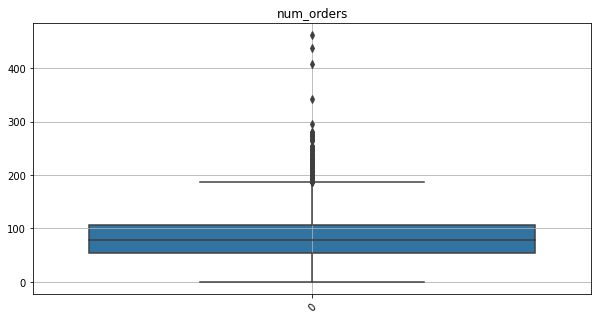

Количество выбивающихся значений в num_orders: 121
Нижняя граница: -25.5
Верхняя граница: 186.5


In [6]:
box(data, 'num_orders')

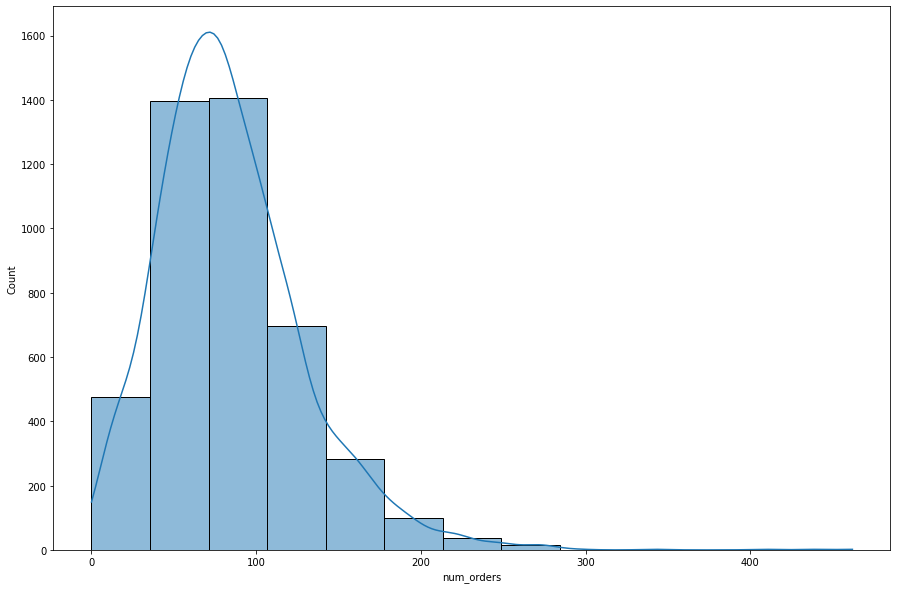

In [7]:
hist(data['num_orders'], 13)

Распределение данных соответствует наши интуитивным представлениям об этом распределении. 

## Анализ

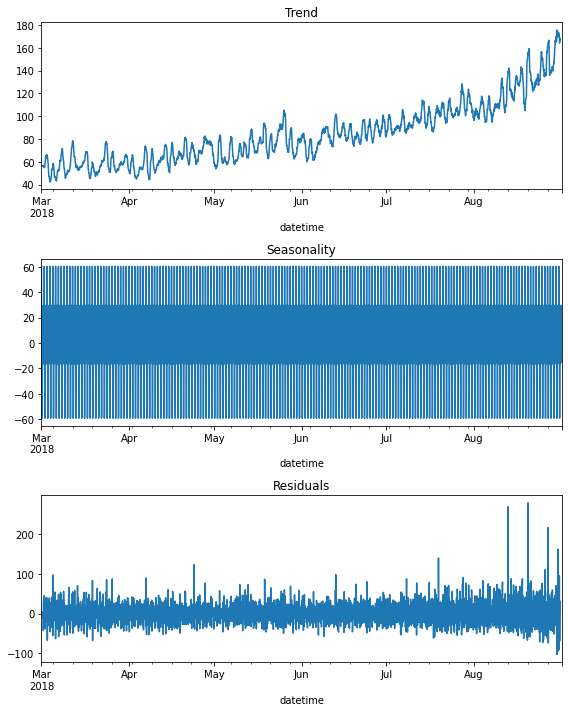

In [8]:
dec(data['num_orders']['2018-03-01':'2018-08-31'])


Посмотрим на последнюю неделю, чтобы увидеть цикличность. 

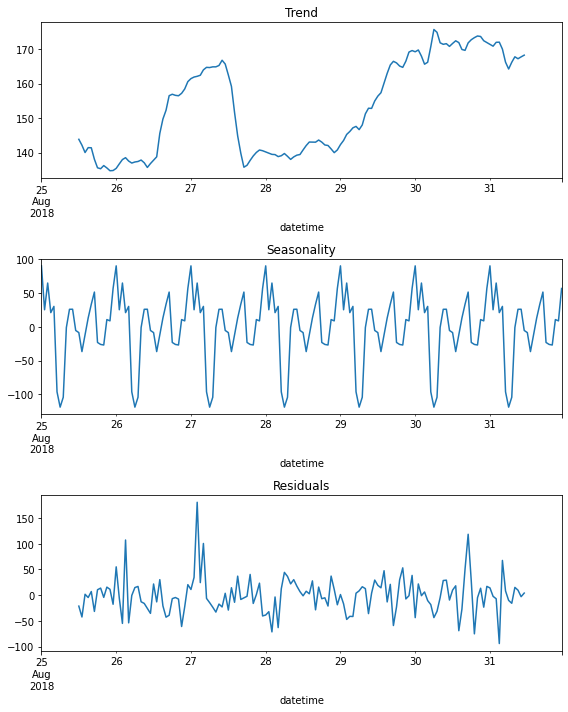

In [9]:
dec(data['num_orders']['2018-08-25':'2018-08-31'])

Также посмотрим на колебания заказов такси в течении последнего дня. 

<AxesSubplot:xlabel='datetime'>

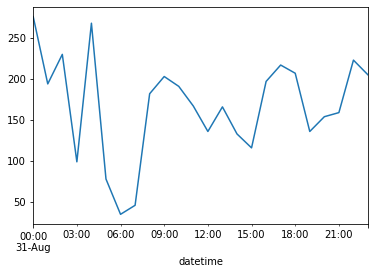

In [10]:
data['num_orders']['2018-08-31':'2018-08-31'].plot()

**Свойства временного ряды:**

1. Предоставленные данные - нестационарный временной ряд, с выраженным возрастающим трендом, дневной и недельной цикличностью. 
2. Чаще всего люди совершают перелёты ночью или ближе к вечеру. Очевидно, что это связано с устройством часовых поясов и поведением людей. 
3. Число заказов явно меняется и от дня недели.

**Работа с признаками:**
1. В признаки необходимо будет добавить месяц, день недели и часы. С помощью месяца можно учесть возрастающий тренд, информация о цикличности будет содержаться в днях недели и часах. 
2. Также в признаки добавим скользящее среднее и lag-признаки, что позволит моделям учесть внутренние тенденции. 

In [11]:
make_features(data, 24, 30)
data = data.dropna()
data.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 06:00:00,11,3,2,4,6,11.0,20.0,64.0,75.0,120.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,58.133333
2018-03-02 07:00:00,7,3,2,4,7,11.0,11.0,20.0,64.0,75.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,54.366667
2018-03-02 08:00:00,46,3,2,4,8,7.0,11.0,11.0,20.0,64.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,51.766667
2018-03-02 09:00:00,45,3,2,4,9,46.0,7.0,11.0,11.0,20.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,50.933333
2018-03-02 10:00:00,54,3,2,4,10,45.0,46.0,7.0,11.0,11.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,50.233333
2018-03-02 11:00:00,91,3,2,4,11,54.0,45.0,46.0,7.0,11.0,...,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,50.600000
2018-03-02 12:00:00,36,3,2,4,12,91.0,54.0,45.0,46.0,7.0,...,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,53.433333
2018-03-02 13:00:00,45,3,2,4,13,36.0,91.0,54.0,45.0,46.0,...,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,54.233333
2018-03-02 14:00:00,44,3,2,4,14,45.0,36.0,91.0,54.0,45.0,...,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,55.233333


## Обучение

Подберём лучшую модель. 

In [12]:
train, test = train_test_split(data, test_size = 0.1, shuffle = False)

X_train = train.drop('num_orders', axis = 1)
Y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
Y_test = test['num_orders']

In [13]:
RANDOM_STATE = 42
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), X_train.columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression(n_jobs=-1))
    ]
)



In [14]:
param_grid = [
    {
        'model': [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'model': [LGBMRegressor()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'model__boosting_type': ['gbdt', 'dart'],
        'model__max_depth': list(range(4,16,4))
    }
]

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipe_final, 
param_grid, 
cv=tscv, 
scoring='neg_mean_squared_error')
grid_search.fit(X_train,Y_train)
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object'))])),
                ('model', LGBMRegressor(max_depth=8))])


## Тестирование

In [15]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
MSE = mean_squared_error(y_pred, Y_test)
print(f'RMSE лучшей модели на тестовой выборки: {round(MSE**0.5,1)}')

RMSE лучшей модели на тестовой выборки: 40.4


Посмотрим графически на то, как модель научилась предсказывать будущие значения. 

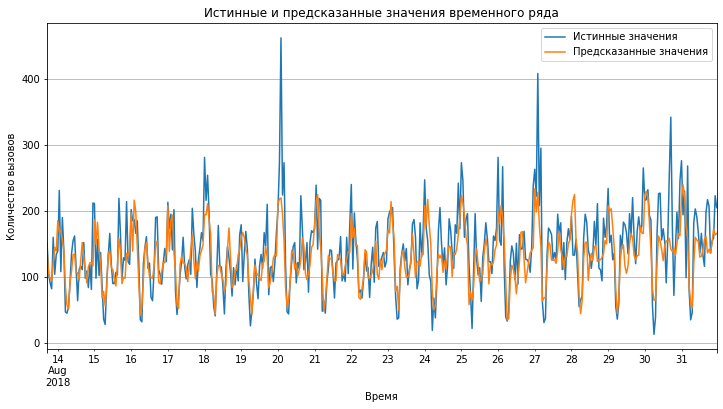

In [28]:
Y_point = pd.DataFrame(Y_test)
Y_point['predict'] = y_pred
Y_point.columns = ['Истинные значения', "Предсказанные значения"]
Y_point.plot(figsize=(12, 6))
plt.title('Истинные и предсказанные значения временного ряда')
plt.xlabel('Время') 
plt.ylabel('Количество вызовов')
plt.grid()
plt.show()

### Общий вывод:

**Ключевая цель и результат:**

Была построена регрессионая модель, которая позволяет предсказывать будущие значения временного ряда с высокой точностью. Поставленная задача успешно выполнена. 

**Что было сделано для выполнения задачи:**

1. Данные подготовлены для анализа. 
2. Проведён первичный анализ данных: наличие дубликатов, распределение данных. 
3. Проведён анализ временного ряда. Выделены и проанализированы ключевые компоненты ряды: тренд, сезонность и шум. 
4. Добавлены признаки, которые будут использоваться моделями для предсказания будущих значений ряда. 
5. С помощью перебора гиперпараметров и способ нормализации была подобрана лучшая модель.
6. Лучшая модель во время обучения была проверена на тестовой выборке. 